In [ ]:
#creating synthetic data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 5000  # number of individuals

# --- 1. Covariate generation ----------------------------------------------
age_at_entry = np.random.randint(25, 60, n)
income_level = np.random.normal(40000, 12000, n).clip(15000, 120000)
health_score = np.random.normal(70, 10, n).clip(40, 100)
pension_contrib_rate = np.random.uniform(0.03, 0.12, n)

# --- 2. Weibull AFT parameters --------------------------------------------
k = 1.8  # shape parameter >1 → hazard increases over time

# regression coefficients for log(scale λ_i)
beta_age = -0.015      # older = earlier claim
beta_income = 0.000015 # higher income = later claim
beta_health = 0.01     # better health = later claim
beta_contrib = -2.0    # higher contrib rate = earlier claim
mu = 2.4             # intercept (base scale level)

# --- 3. Individual scale parameter λ_i -------------------------------------
log_lambda_i = (
    mu
    + beta_age * age_at_entry
    + beta_income * income_level
    + beta_health * health_score
    + beta_contrib * pension_contrib_rate
)
lambda_i = np.exp(log_lambda_i)

# --- 4. True event times (Weibull distributed) -----------------------------
true_time = np.random.weibull(k, n) * lambda_i  # years until claim

# --- 5. Right censoring (EHD-style) ---------------------------------------
admin_censor_time = 25.0  # 5-year follow-up period
# ~30% disenroll randomly before 5 years
disenroll_rate = 0.35
early_censor_time = np.random.uniform(0, admin_censor_time, n)
use_disenroll = np.random.binomial(1, disenroll_rate, n)
censor_time = np.where(use_disenroll == 1, early_censor_time, admin_censor_time)

# Observed time & event indicator
observed_time = np.minimum(true_time, censor_time)
event_observed = (true_time <= censor_time).astype(int)

# --- 6. Combine into a DataFrame ------------------------------------------
df = pd.DataFrame({
    "id": np.arange(1, n + 1),
    "age_at_entry": age_at_entry,
    "income_level": income_level.round(2),
    "health_score": health_score.round(1),
    "pension_contrib_rate": pension_contrib_rate.round(3),
    "true_event_time": true_time.round(3),
    "censor_time": censor_time.round(3),
    "time_to_event": observed_time.round(3),
    "event_observed": event_observed
})

print(df.head())



   id  age_at_entry  income_level  health_score  pension_contrib_rate  \
0   1            53      36794.48          78.4                 0.052   
1   2            39      45557.62          62.0                 0.072   
2   3            32      35686.13          52.1                 0.048   
3   4            45      70045.55          75.5                 0.080   
4   5            43      49361.51          86.3                 0.054   

   true_event_time  censor_time  time_to_event  event_observed  
0            8.653       25.000          8.653               1  
1           32.314       25.000         25.000               0  
2           19.388        1.635          1.635               0  
3           34.158       12.475         12.475               0  
4           15.370        6.202          6.202               0  


In [34]:
df.to_csv("synthetic_survival_data.csv", index=False)

In [35]:
df.shape

(5000, 9)

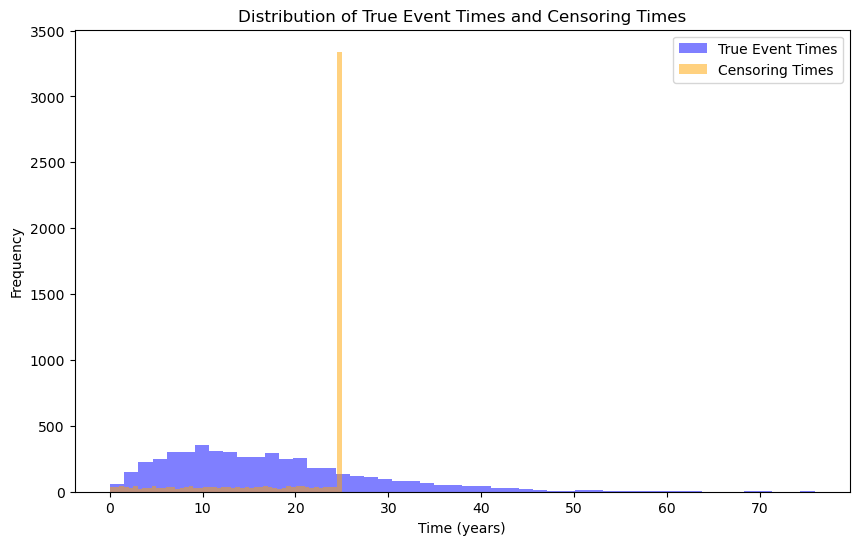

In [36]:
df_copy = df.copy()
df_copy['True_Time'] = true_time.round(2)
df_copy['censor_Time'] = censor_time.round(2)

plt.figure(figsize=(10,6))
plt.hist(df_copy['True_Time'], bins=50, alpha=0.5, label='True Event Times', color='blue')
plt.hist(df_copy['censor_Time'], bins=50, alpha=0.5, label='Censoring Times', color='orange')
plt.xlabel('Time (years)')  
plt.ylabel('Frequency')
plt.title('Distribution of True Event Times and Censoring Times')
plt.legend()
plt.show()

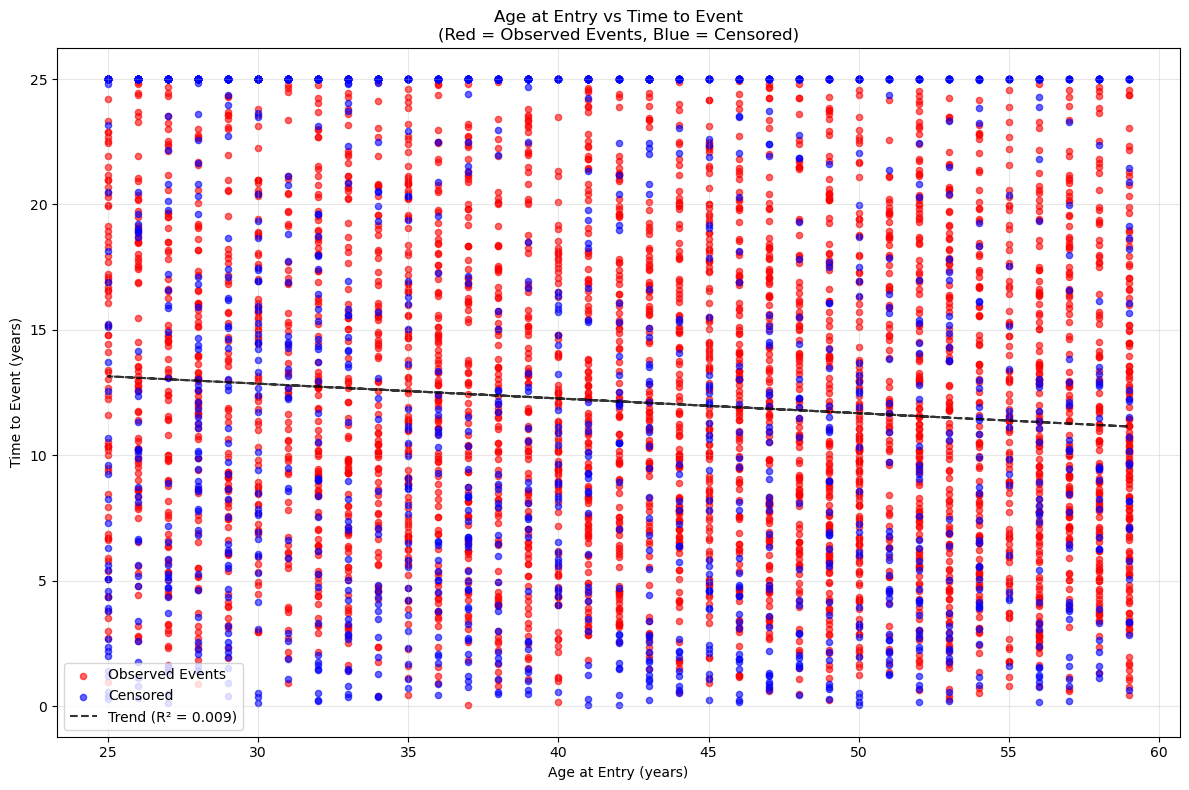

Correlation between age at entry and time to event (observed events only): -0.094
Number of observed events: 3318
Number of censored observations: 1682


In [37]:
# Graph of age at entry vs time to event 
plt.figure(figsize=(12,8))

# Create scatter plot with different colors for censored vs observed events
observed_events = df['event_observed'] == 1
censored_events = df['event_observed'] == 0

plt.scatter(df[observed_events]['age_at_entry'], 
           df[observed_events]['time_to_event'],
           alpha=0.6, s=20, color='red', label='Observed Events')

plt.scatter(df[censored_events]['age_at_entry'], 
           df[censored_events]['time_to_event'],
           alpha=0.6, s=20, color='blue', label='Censored')

plt.xlabel('Age at Entry (years)')
plt.ylabel('Time to Event (years)')
plt.title('Age at Entry vs Time to Event\n(Red = Observed Events, Blue = Censored)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add trend line for observed events only
from scipy import stats
observed_data = df[observed_events]
slope, intercept, r_value, p_value, std_err = stats.linregress(
    observed_data['age_at_entry'], observed_data['time_to_event'])
line = slope * df['age_at_entry'] + intercept
plt.plot(df['age_at_entry'], line, 'black', linestyle='--', alpha=0.8, 
         label=f'Trend (R² = {r_value**2:.3f})')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Correlation between age at entry and time to event (observed events only): {r_value:.3f}")
print(f"Number of observed events: {observed_events.sum()}")
print(f"Number of censored observations: {censored_events.sum()}")